In [1]:
# Use networkx to create a graph with the relations
import networkx as nx
import random
from math import log10
from udpipe2_tuples_generator import run_sequential, break_text_into_sentences

import matplotlib.pyplot as plt

def plot_graph(tuples, name, interesting_subjects = []):
    G = nx.Graph()
    number_of_objects_per_subject = [0, 0]
    random.shuffle(tuples)
    for tuple in tuples:
        subject = tuple[0]
        relation = tuple[1]
        object_ = tuple[2]
        if subject in interesting_subjects and number_of_objects_per_subject[interesting_subjects.index(subject)] < 10:
            G.add_edge(subject, object_, relation=relation)
            number_of_objects_per_subject[interesting_subjects.index(subject)] += 1

    plt.figure(figsize=(30,30))
    pos = nx.spring_layout(G, k=0.5)
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='g')
    if len(interesting_subjects) > 0:
        nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes() if n in interesting_subjects], node_size=1000, node_color='r')
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=16)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'relation'), font_size=16)

    plt.axis('off')
    plt.savefig(name + '.png', dpi=300)


In [2]:
# Create the final graph with all the nodes and edges
def create_graph(tuples):
    G = nx.Graph()
    for string_tuple in tuples:
        subject = string_tuple[0]
        relation = string_tuple[1]
        object_ = string_tuple[2]
        G.add_edge(subject, object_, relation=relation)

In [3]:
def get_all_shortest_paths(G, tuples):
    all_shortest_paths = []
    for tuple in tuples:
        source = tuple[0]
        relation = tuple[1]
        target = tuple[2]
        try:
            for path in nx.all_shortest_paths(G, source=source, target=target):
                all_shortest_paths.append([path, relation])
        except:
            pass
    return all_shortest_paths

def rate_sentence(G, sentence):
    string_tuples = run_sequential(sentence)
    all_shortest_paths = get_all_shortest_paths(G, string_tuples)

    if len(all_shortest_paths) == 0:
        return 0

    def rate_path(G, path, relation):
        if len(path) == 2:
            return 1
        
        score = 1 / (1 + sum([log10(G.degree(node)) for node in path[1:-1]]))

        # add 1 to the score if relation appers in the path
        if relation in path:
            score += 1
        
        return score
    
    return sum([rate_path(G, path, relation) for [path, relation] in all_shortest_paths])/len(all_shortest_paths)

def rate_text(G, text):
    sentences = break_text_into_sentences(text)
    return sum([rate_sentence(G, sentence) for sentence in sentences]) / len(sentences)
        

In [4]:
import pandas as pd

tuples_g1 = pd.read_csv('../data/csvs/g1_tuples_udpipe.csv').values.tolist()
tuples_fakebr = pd.read_csv('../data/csvs/fake_br_corpus_tuples_udpipe.csv').values.tolist()

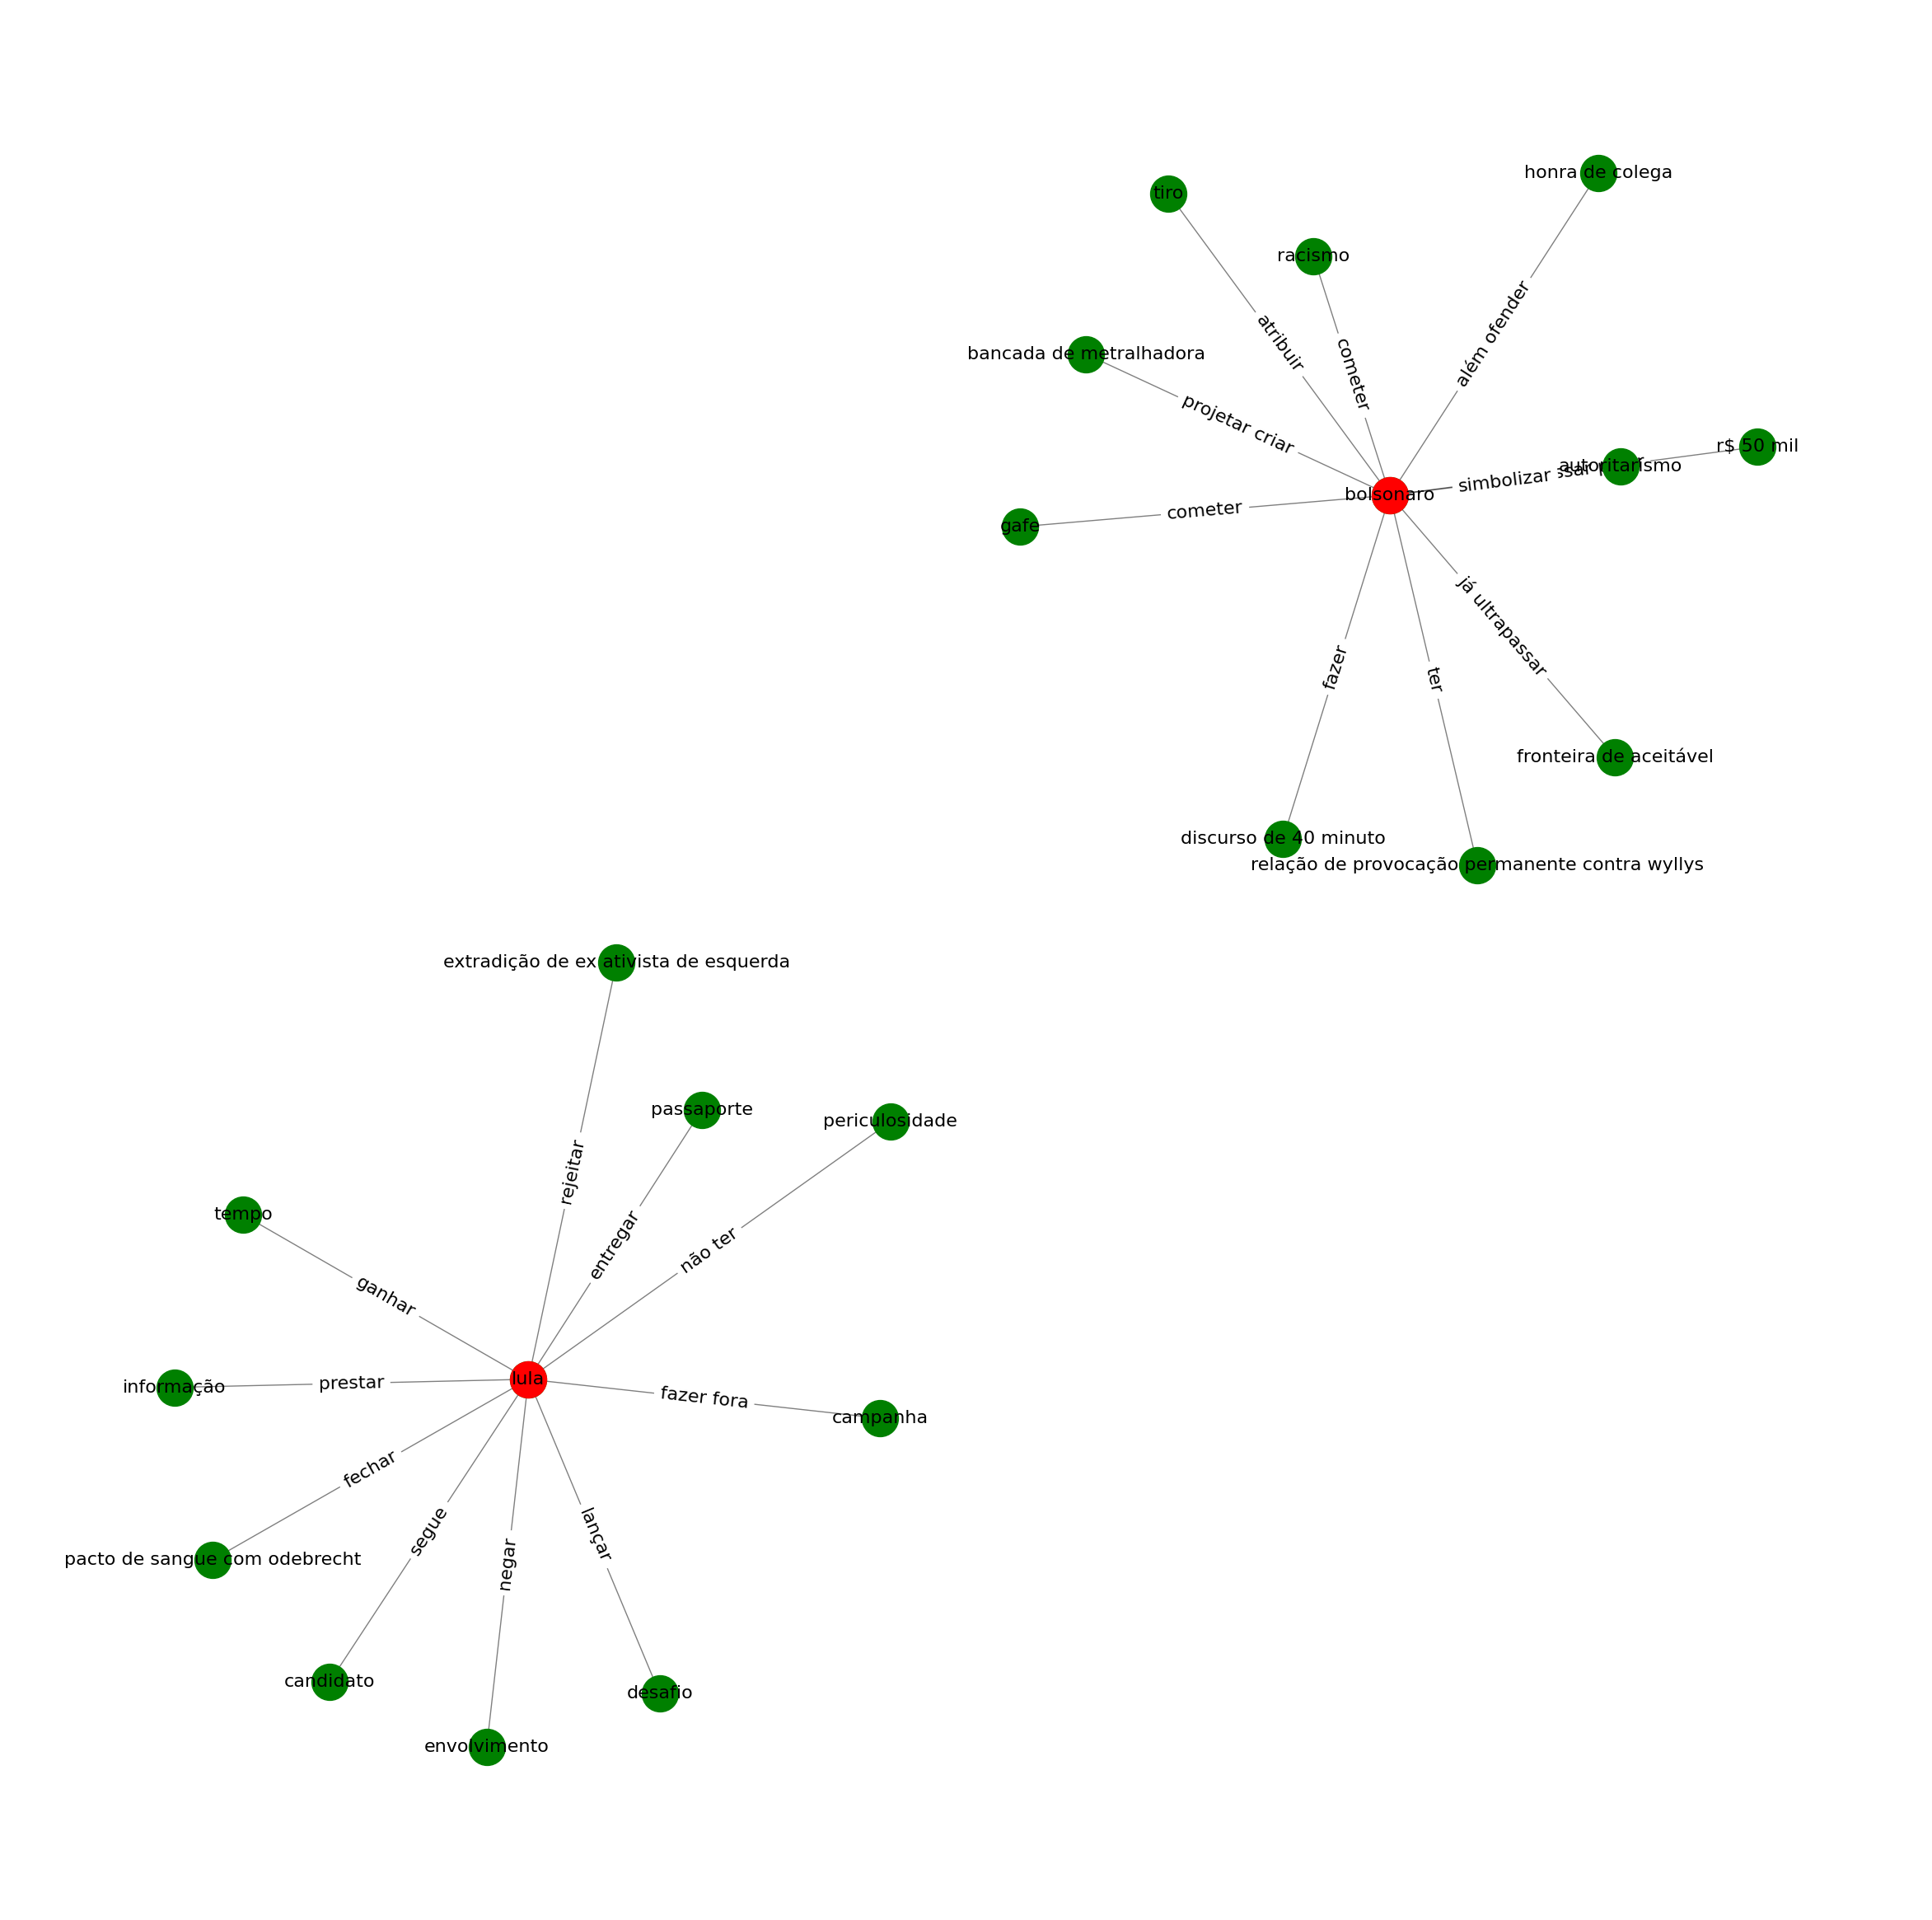

In [5]:
interesting_subjects = ['lula', 'bolsonaro']
plot_graph(tuples_fakebr, 'g1_graph_lula_bolsonaro', interesting_subjects)

In [6]:
sentence = "Governo de SP quer mandar moradores de rua para a casa de parentes ou para abrigos."

# for each triple, find the shortest path between the subject and the object
string_tuples = run_sequential(sentence)
G = create_graph(tuples_g1)
all_shortest_paths = get_all_shortest_paths(G, string_tuples)
rating = rate_sentence(G, sentence)

print(string_tuples)
print(all_shortest_paths)
print(rating)


[('governo de sp', 'querer mandar', 'morador de rua')]
[]
0
